In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import sqlite3

plt.style.use('seaborn')
sns.set_palette("colorblind")
conn = sqlite3.connect('zippedData/im.db')

%matplotlib inline

In [7]:
tn_movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
money_columns = ['production_budget','domestic_gross','worldwide_gross']
tn_movie_budgets['year'] = tn_movie_budgets['release_date'].map(lambda x: x[-4:]).astype(int)
tn_movie_budgets[money_columns] = tn_movie_budgets[money_columns].replace([',','\$'], '', regex = True).astype(int)
tn_movie_budgets['profit'] = tn_movie_budgets['worldwide_gross'] - tn_movie_budgets['production_budget']
tn_movie_budgets['ROI'] = tn_movie_budgets['profit'] / tn_movie_budgets['production_budget']
tn_movie_budgets['profit_margin'] = tn_movie_budgets['profit'] / tn_movie_budgets['worldwide_gross'] * 100
tn_movie_budgets['movie'] = tn_movie_budgets['movie'].str.lower()
tn_movie_budgets['movie'] = tn_movie_budgets['movie'].replace([':','\.','\,',"'",'!'], '', regex = True)
tn_movie_budgets['release_date'] = pd.to_datetime(tn_movie_budgets['release_date'])


tn_movie_budgets

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,profit,ROI,profit_margin
0,1,2009-12-18,avatar,425000000,760507625,2776345279,2009,2351345279,5.532577,84.692106
1,2,2011-05-20,pirates of the caribbean on stranger tides,410600000,241063875,1045663875,2011,635063875,1.546673,60.733080
2,3,2019-06-07,dark phoenix,350000000,42762350,149762350,2019,-200237650,-0.572108,-133.703598
3,4,2015-05-01,avengers age of ultron,330600000,459005868,1403013963,2015,1072413963,3.243841,76.436443
4,5,2017-12-15,star wars ep viii the last jedi,317000000,620181382,1316721747,2017,999721747,3.153696,75.925058
...,...,...,...,...,...,...,...,...,...,...
5777,78,2018-12-31,red 11,7000,0,0,2018,-7000,-1.000000,-inf
5778,79,1999-04-02,following,6000,48482,240495,1999,234495,39.082500,97.505146
5779,80,2005-07-13,return to the land of wonders,5000,1338,1338,2005,-3662,-0.732400,-273.692078
5780,81,2015-09-29,a plague so pleasant,1400,0,0,2015,-1400,-1.000000,-inf


In [5]:
test_sql_df = pd.read_sql("""
SELECT mb.movie_id, mb.primary_title, mb.start_year, mb.runtime_minutes, mb.genres, p.primary_name, 
pr.category, mr.averagerating, mr.numvotes

FROM movie_basics AS mb
JOIN principals AS pr
    USING(movie_id)
JOIN persons AS p
    USING(person_id)
JOIN movie_ratings as mr
    USING(movie_id)
WHERE pr.category IN ('director')
GROUP BY movie_id, person_id
;
""",conn).drop_duplicates(subset = ['movie_id'])

In [6]:
test_sql_df = test_sql_df.drop_duplicates(subset = ['primary_title','start_year'])
test_sql_df['primary_title'] = test_sql_df['primary_title'].str.lower()
test_sql_df['primary_title'] = test_sql_df['primary_title'].replace([':','\.','\,',"'",'!'], '', regex = True)
test_sql_df

,movie_id,primary_title,start_year,runtime_minutes,genres,primary_name,category,averagerating,numvotes
0,tt0063540,sunghursh,2013,175.0,"Action,Crime,Drama",Harnam Singh Rawail,director,7.0,77
1,tt0066787,one day before the rainy season,2019,114.0,"Biography,Drama",Mani Kaul,director,7.2,43
2,tt0069049,the other side of the wind,2018,122.0,Drama,Orson Welles,director,6.9,4517
3,tt0069204,sabse bada sukh,2018,NaN,"Comedy,Drama",Hrishikesh Mukherjee,director,6.1,13
4,tt0100275,the wandering soap opera,2017,80.0,"Comedy,Drama,Fantasy",Raoul Ruiz,director,6.5,119
...,...,...,...,...,...,...,...,...,...
77447,tt9913056,swarm season,2019,86.0,Documentary,Sarah Christman,director,6.2,5
77448,tt9913084,diabolik sono io,2019,75.0,Documentary,Giancarlo Soldi,director,6.2,6
77449,tt9914642,albatross,2017,NaN,Documentary,Chris Jordan,director,8.5,8
77450,tt9914942,la vida sense la sara amat,2019,NaN,None,Laura Jou,director,6.6,5


In [14]:
sql_budgets_merged = test_sql_df.merge(tn_movie_budgets, left_on = ['primary_title','start_year'], right_on = ['movie','year'])
sql_budgets_merged_profit = sql_budgets_merged[sql_budgets_merged['profit'] > 0]
sql_budgets_merged

,movie_id,primary_title,start_year,runtime_minutes,genres,primary_name,category,averagerating,numvotes,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,profit,ROI,profit_margin
0,tt0249516,foodfight,2012,91.0,"Action,Animation,Comedy",Lawrence Kasanoff,director,1.9,8248,26,2012-12-31,foodfight,45000000,0,73706,2012,-44926294,-0.998362,-6.095337e+04
1,tt0365907,a walk among the tombstones,2014,114.0,"Action,Crime,Drama",Scott Frank,director,6.5,105116,67,2014-09-19,a walk among the tombstones,28000000,26017685,62108587,2014,34108587,1.218164,5.491767e+01
2,tt0369610,jurassic world,2015,124.0,"Action,Adventure,Sci-Fi",Colin Trevorrow,director,7.0,539338,34,2015-06-12,jurassic world,215000000,652270625,1648854864,2015,1433854864,6.669092,8.696065e+01
3,tt0376136,the rum diary,2011,119.0,"Comedy,Drama",Bruce Robinson,director,6.2,94787,16,2011-10-28,the rum diary,45000000,13109815,21544732,2011,-23455268,-0.521228,-1.088678e+02
4,tt0383010,the three stooges,2012,92.0,"Comedy,Family",Bobby Farrelly,director,5.1,28570,4,2012-04-13,the three stooges,30000000,44338224,54052249,2012,24052249,0.801742,4.449815e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1466,tt8043306,teefa in trouble,2018,155.0,"Action,Comedy,Crime",Ahsan Rahim,director,7.4,2724,8,2018-07-20,teefa in trouble,1500000,0,98806,2018,-1401194,-0.934129,-1.418126e+03
1467,tt8155288,happy death day 2u,2019,100.0,"Drama,Horror,Mystery",Christopher Landon,director,6.3,27462,78,2019-02-13,happy death day 2u,9000000,28051045,64179495,2019,55179495,6.131055,8.597683e+01
1468,tt8266310,blinded by the light,2019,117.0,"Biography,Comedy,Drama",Gurinder Chadha,director,6.2,173,64,2019-08-14,blinded by the light,15000000,0,0,2019,-15000000,-1.000000,-inf
1469,tt8632862,fahrenheit 11/9,2018,128.0,Documentary,Michael Moore,director,6.7,11628,29,2018-09-21,fahrenheit 11/9,5000000,6352306,6653715,2018,1653715,0.330743,2.485401e+01


In [15]:
genres_list = ['Romance','Thriller','Action','Comedy','Drama','Sci-Fi','Documentary','Animation','Fantasy','Adventure','Family','Sport','War']
genres_dict = {}
genres_dict['Genre'] = []
genres_dict['Median Profit Margin'] = []
genres_dict['Median Budget'] = []
genres_dict['Median ROI'] = []
genres_dict['Number of Films'] = []

for genre in genres_list:
    sql_budgets_merged_profit[genre] = sql_budgets_merged_profit['genres'].str.contains(genre)
    #display(sql_budgets_merged.groupby([genre])[['profit_margin']].agg('median').sort_values(by = 'profit_margin', ascending = False))
    
    genres_dict['Genre'].append(genre)
    genres_dict['Median Profit Margin'].append(sql_budgets_merged_profit.groupby([genre])[['profit_margin']].agg('median').sort_values(by = 'profit_margin', ascending = False).iloc[0][0])
    genres_dict['Median Budget'].append(sql_budgets_merged_profit.groupby([genre])[['production_budget']].agg('median').sort_values(by = 'production_budget', ascending = False).iloc[0][0])
    genres_dict['Median ROI'].append(sql_budgets_merged_profit.groupby([genre])[['ROI']].agg('median').sort_values(by = 'ROI', ascending = False).iloc[0][0])
    genres_dict['Number of Films'].append(sql_budgets_merged_profit['genres'].str.contains(genre).sum() )
    
#print(sql_budgets_merged['profit_margin'].median())

genres_df = pd.DataFrame(genres_dict)
genres_df = genres_df.sort_values(by = 'Median Profit Margin', ascending = False)
display(genres_df)

<ipython-input-15-539cb3a7aebc>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sql_budgets_merged_profit[genre] = sql_budgets_merged_profit['genres'].str.contains(genre)


,Genre,Median Profit Margin,Median Budget,Median ROI,Number of Films
5,Sci-Fi,71.966303,120000000,2.567136,105
1,Thriller,71.165513,35000000,2.468069,171
2,Action,68.810638,78000000,2.206221,336
7,Animation,68.131558,95000000,2.137901,95
0,Romance,67.785608,35000000,2.104204,136
9,Adventure,67.556816,117000000,2.082321,303
10,Family,67.499174,54500000,2.076845,72
8,Fantasy,67.482876,75000000,2.075303,95
3,Comedy,67.191211,32250000,2.047964,390
4,Drama,67.090529,50000000,2.038639,450


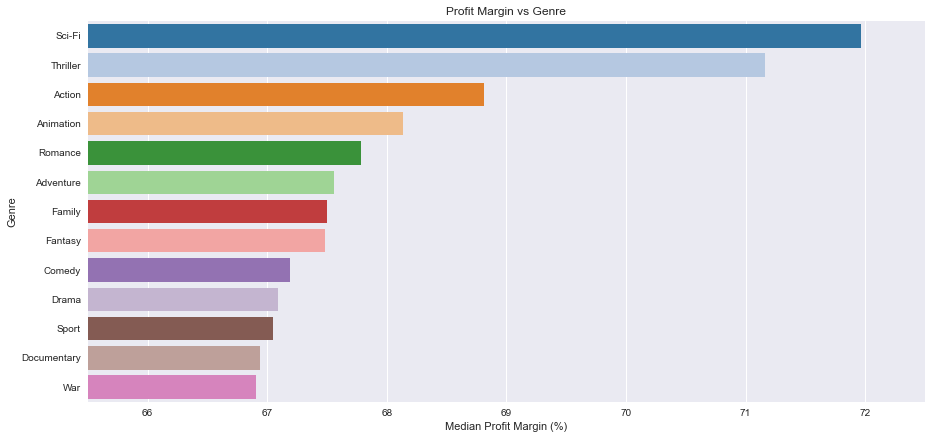

In [23]:
fig,ax = plt.subplots(figsize = (15,7))

ax = sns.barplot(y = 'Genre' , x = 'Median Profit Margin', data = genres_df , palette = 'tab20');
ax.set_xlim(65.5,72.5)
ax.set_xlabel('Median Profit Margin (%)');
ax.set_title('Profit Margin vs Genre');


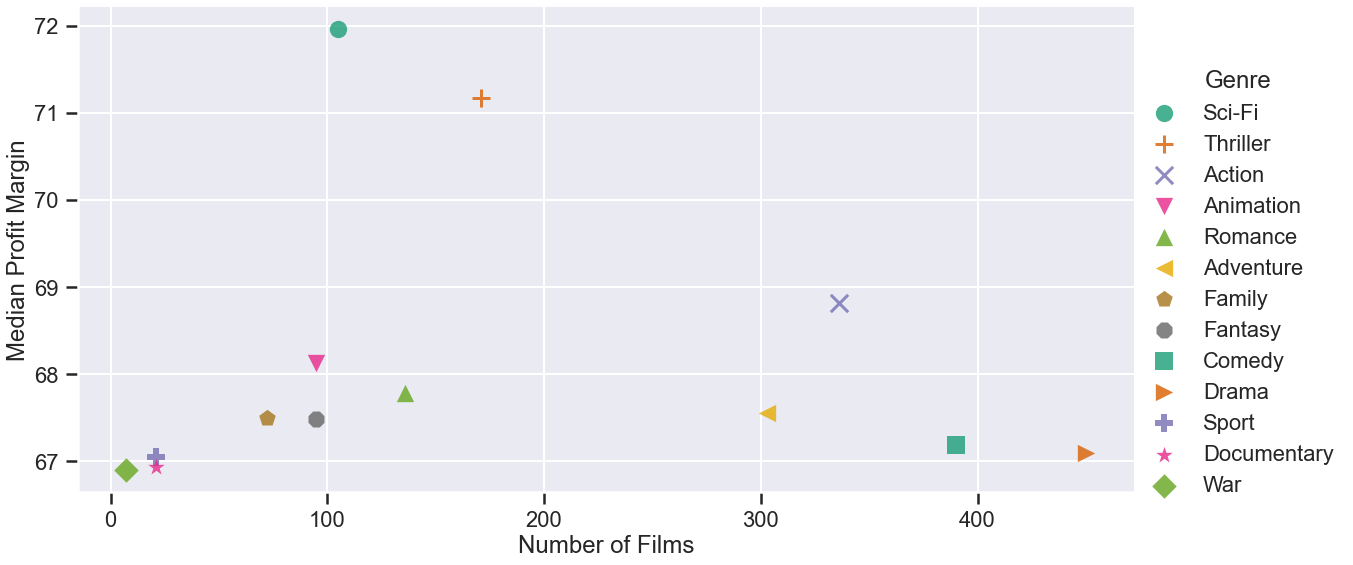

In [24]:
sns.set_context("poster")

sns.lmplot(data = genres_df, x = 'Number of Films', y = 'Median Profit Margin', hue = 'Genre', palette = 'Dark2',
       fit_reg = False, scatter_kws={"s": 300}, height=8, aspect=2, markers=["o","+","x",'v','^','<','p','8','s','>','P','*','D']);

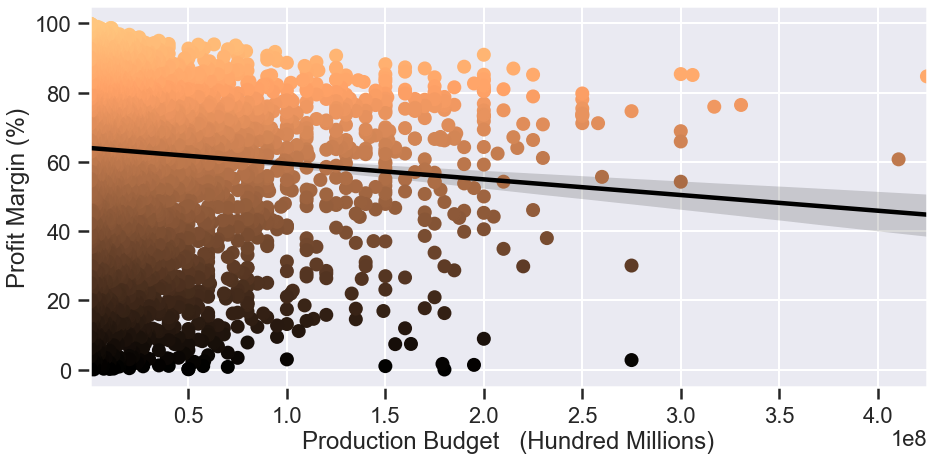

In [25]:
fig, ax = plt.subplots(figsize = (15,7))
profitable_movies = tn_movie_budgets.loc[tn_movie_budgets['profit_margin'] >= 0]


ax = sns.regplot(x ='production_budget', y = 'profit_margin', data = profitable_movies, scatter = False, color = 'black');
ax.scatter(profitable_movies['production_budget'], profitable_movies['profit_margin'], c = profitable_movies["profit_margin"],  cmap="copper");

#ax.hlines(y=60.4, xmin=0, xmax=4e8, linewidth=2, color='cyan')
#ax.vlines(x=0.9e8, ymin=0, ymax=100, linewidth=2, color='cyan')
ax.set_ylabel('Profit Margin (%)');
ax.set_xlabel('Production Budget   (Hundred Millions)');


#current_values = plt.gca().get_xticks()
#plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

#ax.get_xaxis().get_major_formatter().set_useOffset(False)
#ax.set_xticks(ticks = [50e6,100e6,150e6,200e6,250e6,300e6,350e6,400e6,450e6])

In [26]:
rtcurrent = pd.read_csv('zippedData/rotten_tomatoes_movies.csv')
rtcurrent['original_release_date'] = pd.to_datetime(rtcurrent['original_release_date'])
rtcurrent['movie_title'] = rtcurrent['movie_title'].str.lower()
rtcurrent['movie_title'] = rtcurrent['movie_title'].replace([':','\.','\,',"'",'!'], '', regex = True)
rtcurrent

,movie_title,movie_info,content_rating,genres,directors,authors,actors,original_release_date,production_company,tomatometer_status
0,percy jackson & the olympians the lightning thief,"Always trouble-prone, the life of teenager Per...",PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,20th Century Fox,Rotten
1,please give,Kate (Catherine Keener) and her husband Alex (...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,Sony Pictures Classics,Certified-Fresh
2,10,"A successful, middle-aged Hollywood songwriter...",R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,Waner Bros.,Fresh
3,12 angry men (twelve angry men),Following the closing arguments in a murder tr...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,Criterion Collection,Certified-Fresh
4,20000 leagues under the sea,"In 1866, Professor Pierre M. Aronnax (Paul Luk...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,Disney,Fresh
...,...,...,...,...,...,...,...,...,...,...
17707,zoot suit,Mexican-American gangster Henry Reyna (Daniel ...,R,"Drama, Musical & Performing Arts",Luis Valdez,Luis Valdez,"Daniel Valdez, Edward James Olmos, Charles Aid...",1981-10-02,MCA Universal Home Video,Rotten
17708,zootopia,From the largest elephant to the smallest shre...,PG,"Action & Adventure, Animation, Comedy","Byron Howard, Rich Moore, Jared Bush","Jared Bush, Phil Johnston","J.K. Simmons, Kristen Bell, Octavia Spencer, A...",2016-03-04,Walt Disney Animation Studios,Certified-Fresh
17709,zorba the greek,Traveling to inspect an abandoned mine his fat...,NR,"Action & Adventure, Art House & International,...",NaN,NaN,"Anthony Quinn, Alan Bates, Irene Papas, Lila K...",1964-12-17,Fox,Fresh
17710,zulu,"In 1879, the Zulu nation hands colonial Britis...",PG,"Classics, Drama","Cy Endfield, Cyril Endfield","Cy Endfield, John Prebble","Stanley Baker, Jack Hawkins, Ulla Jacobsson, J...",1964-06-17,Paramount Pictures,Fresh


In [27]:
genre_budg = tn_movie_budgets.merge(rtcurrent, left_on = ['movie','release_date'], right_on = ['movie_title','original_release_date'])
genre_budg

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,profit,ROI,profit_margin,movie_title,movie_info,content_rating,genres,directors,authors,actors,original_release_date,production_company,tomatometer_status
0,1,2009-12-18,avatar,425000000,760507625,2776345279,2009,2351345279,5.532577,84.692106,avatar,On the lush alien world of Pandora live the Na...,PG-13,"Action & Adventure, Comedy, Mystery & Suspense...",James Cameron,James Cameron,"Zoe Saldana, Sam Worthington, Sigourney Weaver...",2009-12-18,20th Century Fox,Certified-Fresh
1,2,2011-05-20,pirates of the caribbean on stranger tides,410600000,241063875,1045663875,2011,635063875,1.546673,60.733080,pirates of the caribbean on stranger tides,The checkered past of Capt. Jack Sparrow (John...,PG-13,"Action & Adventure, Comedy, Science Fiction & ...","Dariusz Wolski, Rob Marshall","Rob Marshall, Terry Rossio, Ted Elliott","Johnny Depp, Penelope Cruz, Ian McShane, Geoff...",2011-05-20,Walt Disney Pictures,Rotten
2,3,2019-06-07,dark phoenix,350000000,42762350,149762350,2019,-200237650,-0.572108,-133.703598,dark phoenix,The X-Men face their most formidable and power...,PG-13,"Action & Adventure, Drama, Science Fiction & F...",Simon Kinberg,Simon Kinberg,"James McAvoy, Michael Fassbender, Jennifer Law...",2019-06-07,20th Century Fox,Rotten
3,4,2015-05-01,avengers age of ultron,330600000,459005868,1403013963,2015,1072413963,3.243841,76.436443,avengers age of ultron,When Tony Stark (Robert Downey Jr.) jump-start...,PG-13,"Action & Adventure, Science Fiction & Fantasy",Joss Whedon,"Stan Lee, Jack Kirby, Joss Whedon","Robert Downey Jr., Chris Evans, Mark Ruffalo, ...",2015-05-01,Walt Disney Pictures,Certified-Fresh
4,7,2018-04-27,avengers infinity war,300000000,678815482,2048134200,2018,1748134200,5.827114,85.352522,avengers infinity war,"Iron Man, Thor, the Hulk and the rest of the A...",PG-13,"Action & Adventure, Science Fiction & Fantasy",Anthony Russo,"Christopher Markus, Stephen McFeely","Robert Downey Jr., Chris Hemsworth, Mark Ruffa...",2018-04-27,Walt Disney Pictures,Certified-Fresh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3735,50,2003-06-13,manito,25000,0,0,2003,-25000,-1.000000,-inf,manito,Set and vibrantly photographed in the Washingt...,NR,Drama,Eric Eason,Eric Eason,"Franky G, Leo Minaya, Leo Manaya, Manuel Cabra...",2003-06-13,Film Movement,Fresh
3736,61,2010-04-02,breaking upwards,15000,115592,115592,2010,100592,6.706133,87.023323,breaking upwards,"A young couple (Daryl Wein, Zoe Lister-Jones) ...",NR,"Drama, Romance",Daryl Wein,"Peter Duchan, Zoe Lister-Jones, Daryl Wein","Daryl Wein, Zoe Lister-Jones, Julie White, Oli...",2010-04-02,IFC Films,Fresh
3737,74,1993-02-26,el mariachi,7000,2040920,2041928,1993,2034928,290.704000,99.657187,el mariachi,El Mariachi (Carlos Gallardo) is a traveling g...,R,"Action & Adventure, Art House & International,...",Robert Rodriguez,"Robert Rodriguez, Carlos Gallardo","Carlos Gallardo, Consuelo Gómez, Reinol Martin...",1993-02-26,Sony Pictures Home Entertainment,Fresh
3738,75,2004-10-08,primer,7000,424760,841926,2004,834926,119.275143,99.168573,primer,Intellectual engineers Aaron (Shane Carruth) a...,PG-13,"Drama, Mystery & Suspense, Science Fiction & F...",Shane Carruth,Shane Carruth,"Shane Carruth, David Sullivan, Casey Gooden, A...",2004-10-08,ThinkFilm,Fresh


In [28]:
genre_budg
genre_budg['production_company'] = genre_budg['production_company'].str.lower()
genre_budg['production_company']  = genre_budg['production_company'].replace([':','\.','\,',"'",'!'], '', regex = True)

genre_budg = genre_budg.dropna(subset = ['production_company'])



genre_budg.loc[genre_budg['production_company'].str.contains('century fox'),['production_company'] ] = '20th Century Fox'
genre_budg.loc[genre_budg['production_company'].str.contains('warner'),['production_company'] ] = 'Warner Bros'
genre_budg.loc[genre_budg['production_company'].str.contains('sony'),['production_company'] ] = 'Sony Sictures'
genre_budg.loc[genre_budg['production_company'].str.contains('paramount'),['production_company'] ] = 'Paramount'
genre_budg.loc[genre_budg['production_company'].str.contains('universal'),['production_company'] ] = 'Universal'
genre_budg.loc[genre_budg['production_company'].str.contains('columbia'),['production_company'] ] = 'Columbia Pictures'
genre_budg.loc[genre_budg['production_company'].str.contains('new line'),['production_company'] ] = 'New Line Cinema'
genre_budg.loc[genre_budg['production_company'].str.contains('walt '),['production_company'] ] = 'Walt Disney'
genre_budg.loc[genre_budg['production_company'].str.contains('miramax'),['production_company'] ] = 'Miramax'
genre_budg.loc[genre_budg['production_company'].str.contains('mgm'),['production_company'] ] = 'MGM'
genre_budg.loc[genre_budg['production_company'].str.contains('lionsgate'),['production_company'] ] = 'Lionsgate'
genre_budg.loc[genre_budg['production_company'].str.contains('focus'),['production_company'] ] = 'Focus Features'



/Users/lindstromkyle/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [29]:
top_10_studios = list(genre_budg['production_company'].value_counts().head(10).index)
top_10_df = genre_budg.loc[genre_budg['production_company'].isin(top_10_studios)]
top_10_df = top_10_df.loc[genre_budg['profit'] > 10 ]

top_10_df 

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,profit,ROI,profit_margin,movie_title,movie_info,content_rating,genres,directors,authors,actors,original_release_date,production_company,tomatometer_status
0,1,2009-12-18,avatar,425000000,760507625,2776345279,2009,2351345279,5.532577,84.692106,avatar,On the lush alien world of Pandora live the Na...,PG-13,"Action & Adventure, Comedy, Mystery & Suspense...",James Cameron,James Cameron,"Zoe Saldana, Sam Worthington, Sigourney Weaver...",2009-12-18,20th Century Fox,Certified-Fresh
5,9,2017-11-17,justice league,300000000,229024295,655945209,2017,355945209,1.186484,54.264473,justice league,Fueled by his restored faith in humanity and i...,PG-13,"Action & Adventure, Drama, Science Fiction & F...",Zack Snyder,"Chris Terrio, Joss Whedon","Ben Affleck, Henry Cavill, Amy Adams, Gal Gado...",2017-11-17,Warner Bros,Rotten
6,10,2015-11-06,spectre,300000000,200074175,879620923,2015,579620923,1.932070,65.894399,spectre,A cryptic message from the past leads James Bo...,PG-13,Action & Adventure,Sam Mendes,"Ian Fleming (II), John Logan, Neal Purvis, Rob...","Daniel Craig, Christoph Waltz, Naomie Harris, ...",2015-11-06,Sony Sictures,Fresh
7,11,2012-07-20,the dark knight rises,275000000,448139099,1084439099,2012,809439099,2.943415,74.641268,the dark knight rises,It has been eight years since Batman (Christia...,PG-13,"Action & Adventure, Drama, Mystery & Suspense",Christopher Nolan,"Christopher Nolan, Jonathan Nolan, Bob Kane","Christian Bale, Michael Caine, Gary Oldman, An...",2012-07-20,Warner Bros,Certified-Fresh
11,16,2007-05-04,spider-man 3,258000000,336530303,894860230,2007,636860230,2.468451,71.168682,spider-man 3,Peter Parker (Tobey Maguire) and M.J. (Kirsten...,PG-13,"Action & Adventure, Mystery & Suspense, Scienc...",Sam Raimi,"Alvin Sargent, Ivan Raimi, Sam Raimi, Stan Lee","Tobey Maguire, Kirsten Dunst, James Franco, Th...",2007-05-04,Sony Sictures,Fresh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3714,85,1998-10-09,the mighty,100000,2652246,6121582,1998,6021582,60.215820,98.366435,the mighty,Kevin Dillon (Kieran Culkin) suffers from a di...,PG-13,Drama,Peter Chelsom,Charles Leavitt,"Sharon Stone, Gena Rowlands, Harry Dean Stanto...",1998-10-09,Miramax,Certified-Fresh
3725,16,1995-08-09,the brothers mcmullen,50000,10426506,10426506,1995,10376506,207.530120,99.520453,the brothers mcmullen,"When you're a good Irish Catholic, you choose ...",R,"Comedy, Drama, Romance",Edward Burns,NaN,"Jack Mulcahy, Mike McGlone, Edward Burns, Conn...",1995-08-09,20th Century Fox,Fresh
3733,43,1994-10-19,clerks,27000,3073428,3894240,1994,3867240,143.231111,99.306668,clerks,Dante (Brian O'Halloran) is called in to cover...,R,"Comedy, Cult Movies, Drama",NaN,NaN,"Brian O'Halloran, Jeff Anderson, Marilyn Ghigl...",1994-10-19,Miramax,Certified-Fresh
3734,47,1997-08-01,in the company of men,25000,2883661,2883661,1997,2858661,114.346440,99.133046,in the company of men,Chad (Aaron Eckhart) and Howard (Matt Malloy) ...,R,"Art House & International, Comedy, Drama",Neil LaBute,Neil LaBute,"Aaron Eckhart, Stacy Edwards, Matt Malloy, Mic...",1997-08-01,Sony Sictures,Certified-Fresh


In [30]:
top_10_profit_margins = top_10_df.groupby(['production_company'])[['profit_margin']].mean().sort_values(by = 'profit_margin', ascending = False)
top_10_profit_margins.rename(index = {'production_company': 'Production Company'}, columns = {'profit_margin' : 'Median Profit Margin'}, inplace = True)
top_10_profit_margins.index.names = ['Production Company']
display(top_10_profit_margins)
np.median(top_10_profit_margins.values)


,Median Profit Margin
Production Company,
20th Century Fox,63.857508
Universal,63.252301
Lionsgate,61.577909
Miramax,61.569841
Sony Sictures,61.158969
Paramount,60.630602
MGM,60.008739
New Line Cinema,58.419637
Warner Bros,57.205628


60.89478514142517

In [63]:
title_vs_gross = pd.DataFrame(tn_movie_budgets[['movie','ROI','profit_margin']])

title_vs_gross['movie'] = title_vs_gross['movie'].str.lower()
title_vs_gross['movie'] = title_vs_gross['movie'].replace([':','\.','\,',"'",'!'], '', regex = True)
#title_vs_gross['movie'] = title_vs_gross['movie'].str.replace(r'(\w{2,})s\b', r'\1')


cleaned_titles_success = title_vs_gross.loc[title_vs_gross['ROI'] >= 1 ]
cleaned_titles_fail = title_vs_gross.loc[title_vs_gross['ROI'] <= 0 ]


words_success = cleaned_titles_success['movie'].str.split(expand=True).stack().value_counts()
words_fail = cleaned_titles_fail['movie'].str.split(expand=True).stack().value_counts()


words_success = words_success.reset_index()
words_fail = words_fail.reset_index()


words_success = words_success.rename(columns = {0:'count','index':'word'})
words_fail = words_fail.rename(columns = {0:'count','index':'word'})


stopwords = ['the','and','of','a','to','in','2','3','on','&','with','ii','for','is','it','harry','from','part',"0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz",]


words_success = words_success[~words_success['word'].isin(stopwords)]
words_fail = words_fail[~words_fail['word'].isin(stopwords)]


words_difference = words_success.merge(words_fail, on = 'word')

words_difference['difference'] = words_difference['count_x'] - words_difference['count_y']

display(words_difference.sort_values(by = 'difference', ascending = False).head(10))

#print(len(cleaned_titles_success))
#print(len(cleaned_titles_fail))

,word,count_x,count_y,difference
0,movie,37,11,26
3,star,24,3,21
2,day,27,6,21
11,street,15,3,12
6,night,21,10,11
5,house,21,10,11
25,mad,10,1,9
24,wedding,10,1,9
1,man,34,25,9
30,13th,9,1,8


In [34]:
blood_roi = title_vs_gross.loc[title_vs_gross['movie'].str.contains('blood')]
print('Median ROI for movies with "blood" in the title:',blood_roi['ROI'].median())
dead_roi = title_vs_gross.loc[title_vs_gross['movie'].str.contains('dead')]
print('Median ROI for movies with "dead" in the title:',dead_roi['ROI'].median())

Median ROI for movies with "blood" in the title: -0.47600966
Median ROI for movies with "dead" in the title: -0.098728895


In [35]:
evil_roi = title_vs_gross.loc[title_vs_gross['movie'].str.contains('evil')]
print('Median ROI for movies with "evil" in the title:',evil_roi['profit_margin'].median())
night_roi = title_vs_gross.loc[title_vs_gross['movie'].str.contains('night')]
print('Median ROI for movies with "night" in the title:',night_roi['profit_margin'].median())

Median ROI for movies with "evil" in the title: 60.05392209207773
Median ROI for movies with "night" in the title: 57.305423148406106


In [39]:
thriller_boxplot_df = pd.concat([blood_roi,dead_roi,evil_roi,night_roi])

thriller_boxplot_df.loc[thriller_boxplot_df['movie'].str.contains('blood'),['Word in Title']] = 'blood'
thriller_boxplot_df.loc[thriller_boxplot_df['movie'].str.contains('dead'),['Word in Title']] = 'dead'
thriller_boxplot_df.loc[thriller_boxplot_df['movie'].str.contains('evil'),['Word in Title']] = 'evil'
thriller_boxplot_df.loc[thriller_boxplot_df['movie'].str.contains('night'),['Word in Title']] = 'night'

#thriller_boxplot_df

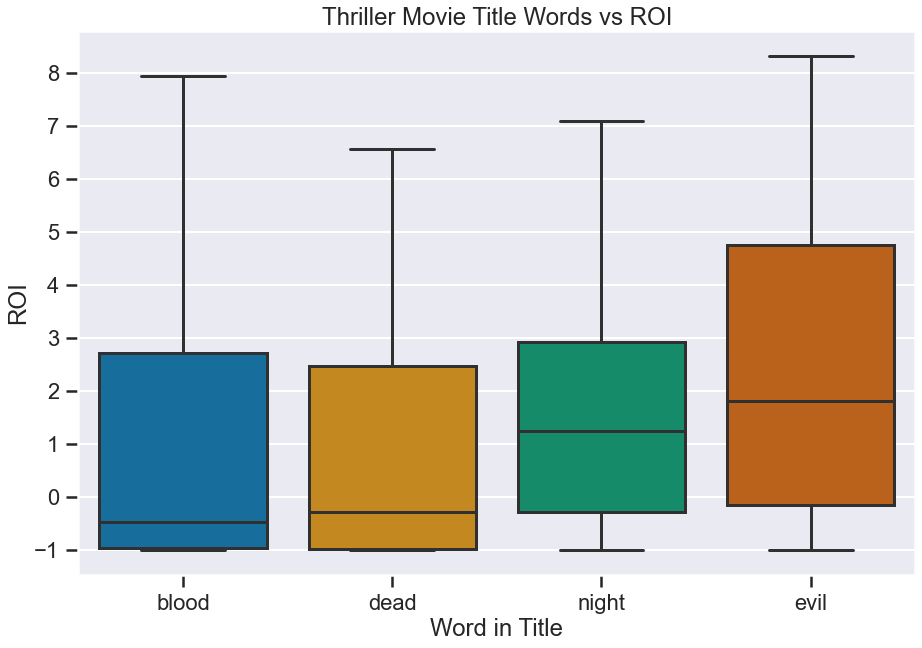

In [40]:
fig, ax = plt.subplots(figsize = (15,10))

ax = sns.boxplot(x = thriller_boxplot_df['Word in Title'], y = thriller_boxplot_df['ROI'], showfliers = False)
ax.set_title("Thriller Movie Title Words vs ROI");
ax.set_yticks(np.arange(-1,9));

In [41]:
alien_roi = title_vs_gross.loc[title_vs_gross['movie'].str.contains('alien')]
print('Median ROI for movies with "alien" in the title:',alien_roi['ROI'].median())

extra_mars = title_vs_gross.loc[title_vs_gross['movie'].str.contains('martian')]
mars_roi = title_vs_gross.loc[title_vs_gross['movie'].str.contains('mars')]
mars_roi = mars_roi.drop([801,1875,3406,4162,5144])
mars_roi= mars_roi.append(extra_mars)
print('Median ROI for movies with "mars" in the title:',mars_roi['ROI'].median())

Median ROI for movies with "alien" in the title: 1.4589819278350515
Median ROI for movies with "mars" in the title: -0.5846114166666667


In [42]:
scifi_boxplot_df = pd.concat([alien_roi,mars_roi])

scifi_boxplot_df.loc[scifi_boxplot_df['movie'].str.contains('mar'),['Word in Title']] = 'mars'
scifi_boxplot_df.loc[scifi_boxplot_df['movie'].str.contains('alien'),['Word in Title']] = 'alien'

#scifi_boxplot_df

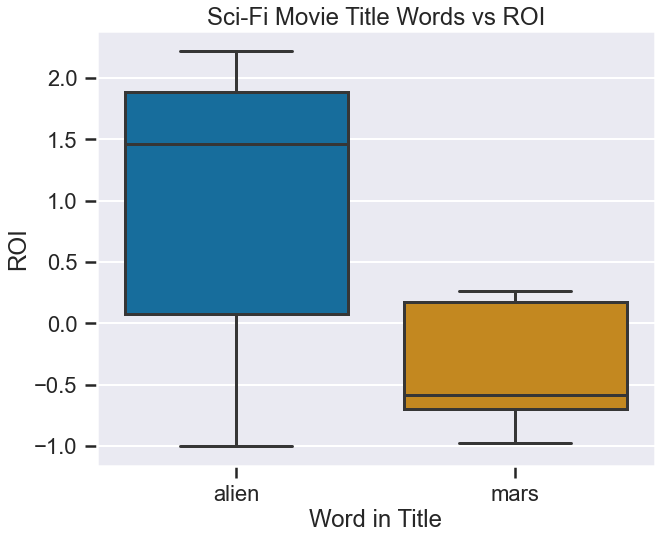

In [43]:
fig, ax = plt.subplots(figsize = (10,8))

ax = sns.boxplot(x = scifi_boxplot_df['Word in Title'], y =scifi_boxplot_df['ROI'], showfliers = False)
ax.set_title("Sci-Fi Movie Title Words vs ROI");

In [46]:
wedding_roi = title_vs_gross.loc[title_vs_gross['movie'].str.contains('wedding')]
print('Median ROI for movies with "wedding" in the title:',wedding_roi['ROI'].median())
love_roi = title_vs_gross.loc[title_vs_gross['movie'].str.contains('love')]
print('Median ROI for movies with "love" in the title:',love_roi['ROI'].median())

Median ROI for movies with "wedding" in the title: 2.434441657608696
Median ROI for movies with "love" in the title: 0.12843673846153847


In [47]:
romance_boxplot_df = pd.concat([wedding_roi,love_roi])

romance_boxplot_df['Word in Title'] = romance_boxplot_df['movie'].str.contains('wedding')
romance_boxplot_df.loc[romance_boxplot_df['Word in Title'] == True, ['Word in Title']] = 'Wedding'
romance_boxplot_df.loc[romance_boxplot_df['Word in Title'] == False, ['Word in Title']] = 'Love'

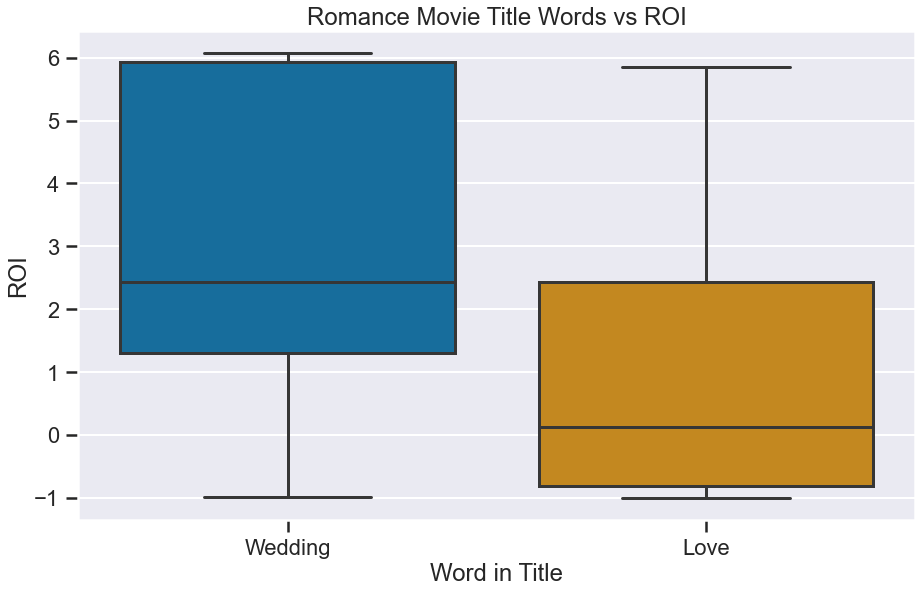

In [48]:
fig, ax = plt.subplots(figsize = (15,9))

ax = sns.boxplot(x = romance_boxplot_df['Word in Title'], y = romance_boxplot_df['ROI'], showfliers = False)
ax.set_title("Romance Movie Title Words vs ROI");

In [44]:
directors_atleast3_list = list(sql_budgets_merged['primary_name'].value_counts().head(122).index)
remove_list = ['David Ayer', 'Joe Johnston', 'Mike Flanagan', 'Dan Gilroy', 'Frank Coraci']

directors_atleast3_list_cleaned = [i for i in directors_atleast3_list if i not in remove_list]

In [45]:
directors_atleast3_df = sql_budgets_merged.loc[sql_budgets_merged['primary_name'].isin(directors_atleast3_list_cleaned)]
directors_atleast3_df

,movie_id,primary_title,start_year,runtime_minutes,genres,primary_name,category,averagerating,numvotes,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,profit,ROI,profit_margin
4,tt0383010,the three stooges,2012,92.0,"Comedy,Family",Bobby Farrelly,director,5.1,28570,4,2012-04-13,the three stooges,30000000,44338224,54052249,2012,24052249,0.801742,44.498147
11,tt0433035,real steel,2011,127.0,"Action,Drama,Family",Shawn Levy,director,7.1,283534,31,2011-10-07,real steel,110000000,85463309,263880341,2011,153880341,1.398912,58.314439
14,tt0437086,alita battle angel,2019,122.0,"Action,Adventure,Sci-Fi",Robert Rodriguez,director,7.5,88207,24,2019-02-14,alita battle angel,170000000,85710210,402976036,2019,232976036,1.370447,57.813869
15,tt0443272,lincoln,2012,150.0,"Biography,Drama,History",Steven Spielberg,director,7.4,228701,73,2012-11-09,lincoln,65000000,182207973,273346281,2012,208346281,3.205327,76.220639
17,tt0446029,scott pilgrim vs the world,2010,112.0,"Action,Comedy,Fantasy",Edgar Wright,director,7.5,339338,22,2010-08-13,scott pilgrim vs the world,85000000,31611316,48056764,2010,-36943236,-0.434626,-76.874165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,tt7137846,breaking in,2018,88.0,"Action,Crime,Drama",James McTeigue,director,5.4,10154,19,2018-05-11,breaking in,6000000,46840590,51411620,2018,45411620,7.568603,88.329487
1452,tt7153766,unsane,2018,98.0,"Drama,Horror,Mystery",Steven Soderbergh,director,6.4,32049,70,2018-03-23,unsane,1500000,7690044,14244931,2018,12744931,8.496621,89.469938
1457,tt7401588,instant family,2018,118.0,"Comedy,Drama",Sean Anders,director,7.4,46728,20,2018-11-16,instant family,48000000,67363237,119736188,2018,71736188,1.494504,59.911869
1465,tt7958736,ma,2019,99.0,"Horror,Thriller",Tate Taylor,director,6.0,5322,66,2019-05-31,ma,5000000,36049540,44300625,2019,39300625,7.860125,88.713478


In [49]:
romance_directors = directors_atleast3_df.loc[directors_atleast3_df['genres'].str.contains('Romance')]
thriller_directors = directors_atleast3_df.loc[directors_atleast3_df['genres'].str.contains('Thriller') ]
scifi_directors = directors_atleast3_df.loc[directors_atleast3_df['genres'].str.contains('Sci')]

In [50]:
rom_keep = list(romance_directors['primary_name'].value_counts().loc[lambda x: x>=2].reset_index()['index'])
thri_keep = list(thriller_directors['primary_name'].value_counts().loc[lambda x: x>=2].reset_index()['index'])
sci_keep = list(scifi_directors['primary_name'].value_counts().loc[lambda x: x>=2].reset_index()['index'])

rom_dir = romance_directors.loc[romance_directors['primary_name'].isin(rom_keep)]
thri_dir = thriller_directors.loc[thriller_directors['primary_name'].isin(thri_keep)]
sci_dir = scifi_directors.loc[scifi_directors['primary_name'].isin(sci_keep)]

#sci_dir['primary_name'].value_counts()

In [51]:
thriller_director_rois = thri_dir.groupby(['primary_name'])[['ROI']].agg('median').sort_values(by = 'ROI', ascending = False)
#thriller_director_rois

In [52]:
scifi_director_rois = sci_dir.groupby(['primary_name'])[['ROI']].agg('median').sort_values(by = 'ROI', ascending = False)
# scifi_director_rois

In [53]:
romance_director_rois = rom_dir.groupby(['primary_name'])[['ROI']].agg('median').sort_values(by = 'ROI', ascending = False)
# romance_director_rois

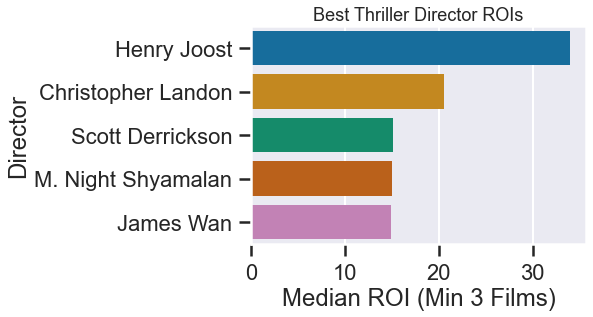

In [60]:
fig,ax = plt.subplots()

sns.set_context("talk")
ax = sns.barplot( y = thriller_director_rois.index[:5], x = thriller_director_rois.ROI[:5], data = thriller_director_rois);

ax.set_title('Best Thriller Director ROIs')
ax.set_ylabel('Director')
ax.set_xlabel('Median ROI (Min 3 Films)');

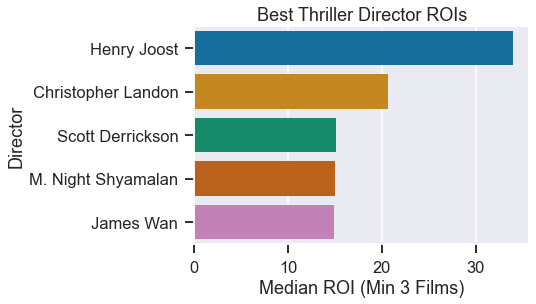

In [61]:
fig,ax = plt.subplots()

ax = sns.barplot( y = thriller_director_rois.index[:5], x = thriller_director_rois.ROI[:5], data = thriller_director_rois)

ax.set_title('Best Thriller Director ROIs')
ax.set_ylabel('Director')
ax.set_xlabel('Median ROI (Min 3 Films)');

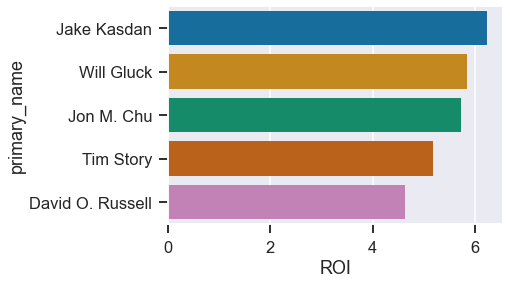

In [62]:
fig,ax = plt.subplots()

ax = sns.barplot( y = romance_director_rois.index[:5], x = romance_director_rois.ROI[:5], data = romance_director_rois)